In [ ]:
# prompt: .  Use the CIFAR10 dataset provided in Keras, after conversion to gray-level images! Use randomly selected 70% of the dataset as training set and remaining 30% as the test set.

import tensorflow as tf
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Load the CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Convert images to grayscale
x_train = np.dot(x_train[..., :3], [0.2989, 0.5870, 0.1140])
x_test = np.dot(x_test[..., :3], [0.2989, 0.5870, 0.1140])

# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape the grayscale images to have a single channel
x_train = x_train.reshape(x_train.shape[0], 32, 32, 1)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 1)

# Split the data into training and testing sets (70/30 split)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
x_train shape: (35000, 32, 32, 1)
y_train shape: (35000, 1)
x_val shape: (15000, 32, 32, 1)
y_val shape: (15000, 1)
x_test shape: (10000, 32, 32, 1)
y_test shape: (10000, 1)


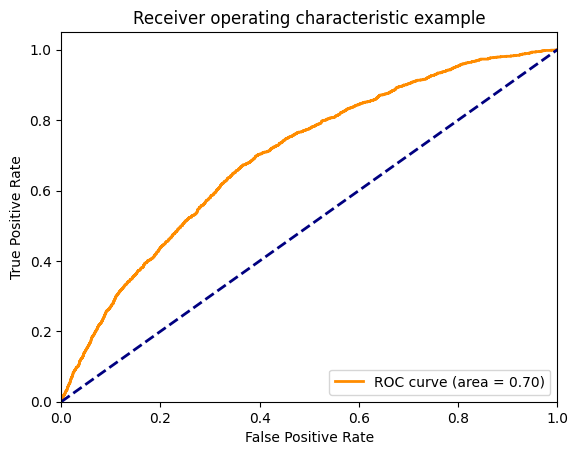

In [ ]:
# prompt: Perform standard PCA with 70% of the training dataset and identify the eigenvectors associated with top eigenvalues with 95% total energy. With these, train a logistic regression classifier to classify the images into 10 classes. Draw the ROC curve for the test dataset. Repeat the same with randomized PCA and compare.

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Flatten the images for PCA
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Standard PCA
pca = PCA(n_components=0.95)  # Keep components explaining 95% of variance
x_train_pca = pca.fit_transform(x_train_flat)
x_val_pca = pca.transform(x_val_flat)

# Train Logistic Regression
clf = LogisticRegression(max_iter=1000) # Increased max_iter
clf.fit(x_train_pca, y_train.ravel())

# Predictions on validation set
y_score = clf.predict_proba(x_val_pca)

# Binarize the output
y_val_bin = label_binarize(y_val, classes=np.unique(y_train))
n_classes = y_val_bin.shape[1]


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()




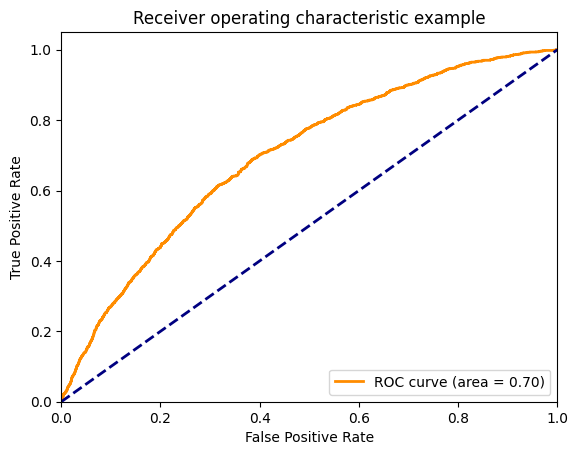

In [ ]:
# Randomized PCA
rpca = PCA(n_components=pca.n_components_, svd_solver='randomized', random_state=42)
x_train_rpca = rpca.fit_transform(x_train_flat)
x_val_rpca = rpca.transform(x_val_flat)

# Train Logistic Regression with Randomized PCA
clf_rpca = LogisticRegression(max_iter=1000)
clf_rpca.fit(x_train_rpca, y_train.ravel())

# Predictions on validation set
y_score = clf_rpca.predict_proba(x_val_pca)

# Binarize the output
y_val_bin = label_binarize(y_val, classes=np.unique(y_train))
n_classes = y_val_bin.shape[1]


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# prompt:  Train a single layer autoencoder with linear activation function and appropriately mean and variance normalized input with constraint that encoder weight matrix and decoder weight matrix are transpose w,r,t, each other. Compare the eigenvectors obtained in step 1 with those obtained using the autoencoders. Explain your observation

import tensorflow as tf
import numpy as np
from tensorflow import keras
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ... (Your existing code for data loading and preprocessing) ...

# Normalize the data (mean and variance)
x_train_mean = np.mean(x_train_flat, axis=0)
x_train_std = np.std(x_train_flat, axis=0)
x_train_norm = (x_train_flat - x_train_mean) / x_train_std
x_val_norm = (x_val_flat - x_train_mean) / x_train_std # Normalize val with training mean/std

# Define the autoencoder
latent_dim = 100  # Example latent dimension
encoder_input = keras.Input(shape=(x_train_norm.shape[1],))
encoded = keras.layers.Dense(latent_dim, activation='linear', use_bias=False, name='encoder')(encoder_input)
decoder_output = keras.layers.Dense(x_train_norm.shape[1], activation='linear', use_bias=False, name='decoder', weights=[np.transpose(np.array(encoded.weights))])(encoded)
autoencoder = keras.Model(encoder_input, decoder_output)

# Constraint: encoder and decoder weights are transposes of each other
# Achieved in model definition above, see decoder layer weights initialization

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(x_train_norm, x_train_norm, epochs=10, batch_size=256, validation_data=(x_val_norm, x_val_norm)) # Use normalized data

# Get encoder weights
encoder_weights = autoencoder.get_layer('encoder').get_weights()[0]

# Calculate Eigenvectors using Autoencoder
eigenvalues, eigenvectors = np.linalg.eig(encoder_weights)

# Calculate Eigenvectors using PCA
pca = PCA(n_components=latent_dim)
pca.fit(x_train_norm)
pca_eigenvectors = pca.components_

# Comparison (Example: plot first 5 eigenvectors)

# Eigenvectors obtained from autoencoder
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(eigenvectors[:, i].reshape(32, 32), cmap='gray')
    plt.title(f"AE Eigenvector {i+1}")
plt.show()

#Eigenvectors obtained from PCA
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pca_eigenvectors[i,:].reshape(32, 32), cmap='gray')
    plt.title(f"PCA Eigenvector {i+1}")
plt.show()

#Further comparison and analysis (e.g. cosine similarity, correlation)
# can be performed here between 'eigenvectors' and 'pca_eigenvectors'

AttributeError: 'KerasTensor' object has no attribute 'weights'